In [25]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_20newsgroups
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import json


## 1. 数据加载与探索

In [26]:
# 加载数据集并查看样本
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
train_dataset_raw = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_dataset_raw = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

sample = {
    "text_preview": train_dataset_raw.data[0][:200],
    "label": train_dataset_raw.target_names[train_dataset_raw.target[0]],
}
sample


{'text_preview': 'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard',
 'label': 'comp.graphics'}

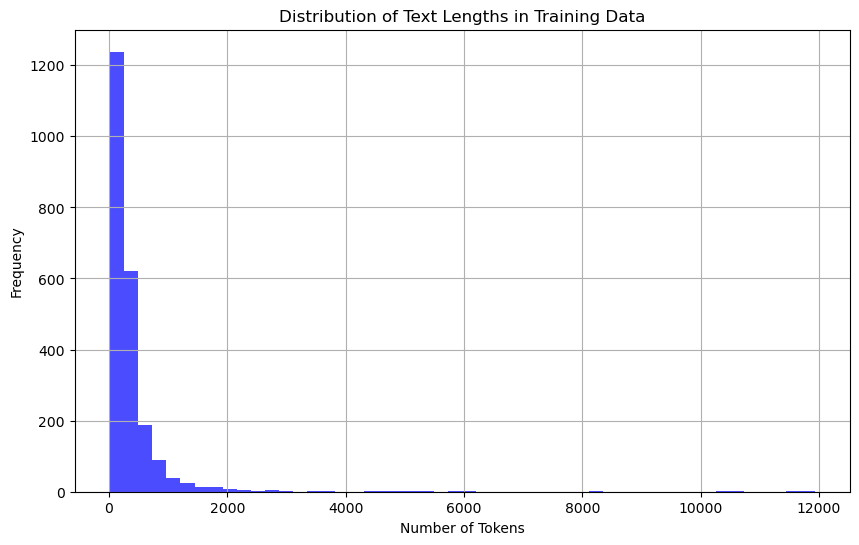

In [27]:
# 训练集文本长度分布

def basic_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9(),.!?\'`]", " ", text)
    text = re.sub(r"([,.!?\'`])", r" \1 ", text)
    return text.strip().split()

train_text_lengths = [len(basic_tokenize(text)) for text in train_dataset_raw.data]

plt.figure(figsize=(10, 6))
plt.hist(train_text_lengths, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Text Lengths in Training Data')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


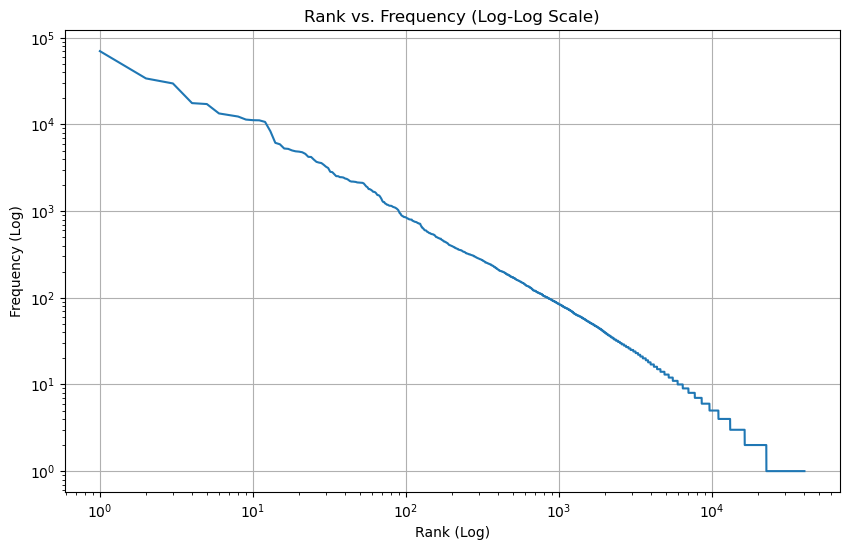

In [28]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(basic_tokenize(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()

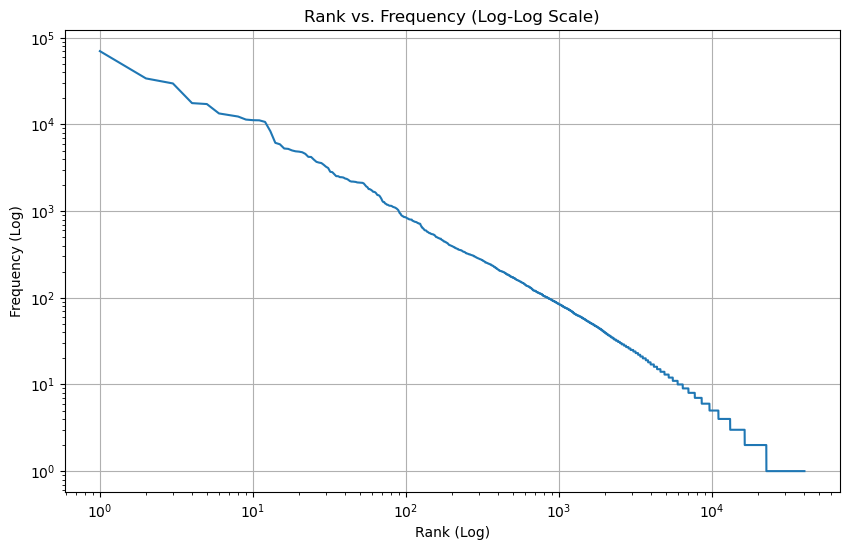

In [29]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(basic_tokenize(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()

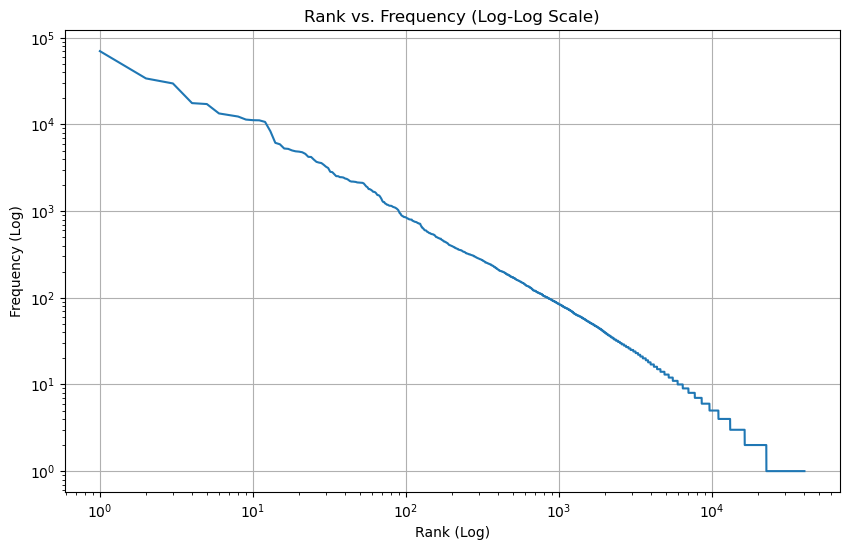

In [30]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(basic_tokenize(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()

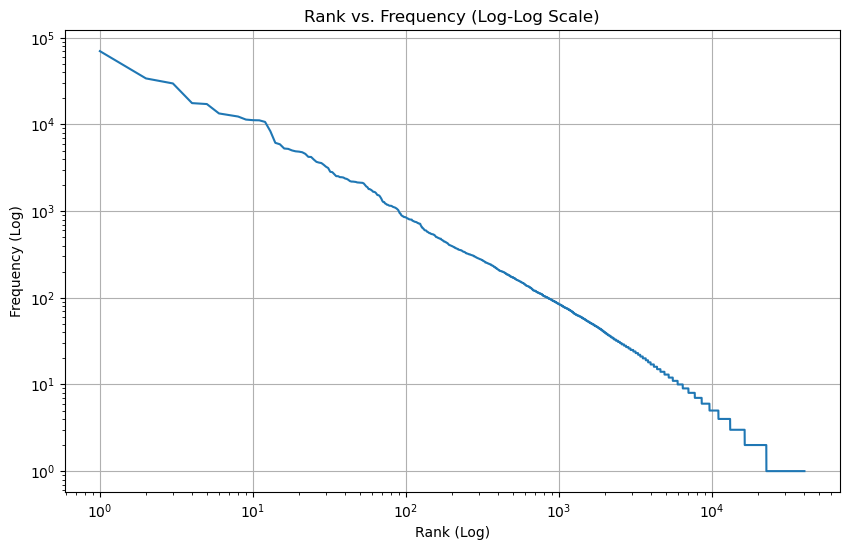

In [31]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(basic_tokenize(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()

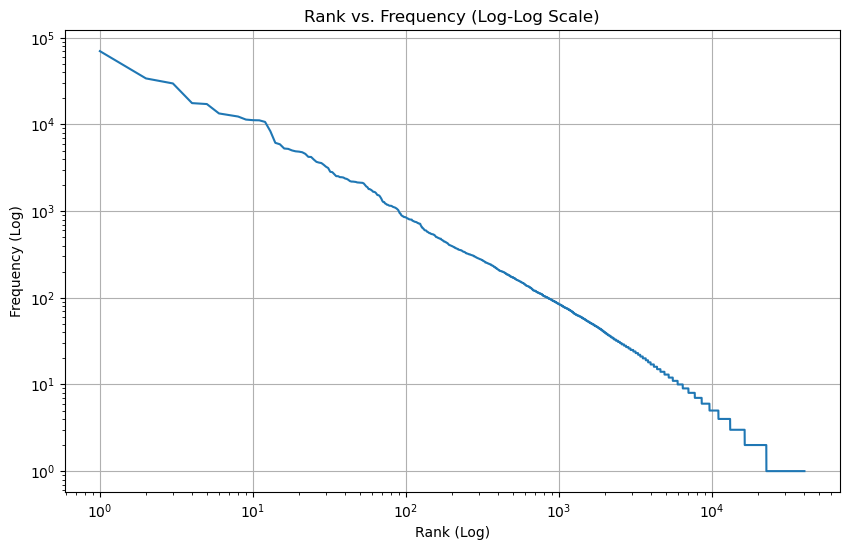

In [32]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(basic_tokenize(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()

In [33]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(_tokenize_text_for_eda(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()

NameError: name '_tokenize_text_for_eda' is not defined

In [ ]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(_tokenize_text_for_eda(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()

## 2. 定义所需组件

In [ ]:
class Tokenizer:
    def __init__(self, vocab, do_lower_case=True):
        self.vocab = vocab
        self.token_to_id = {token: idx for token, idx in vocab.items()}
        self.id_to_token = {idx: token for token, idx in vocab.items()}
        self.do_lower_case = do_lower_case

    @staticmethod
    def _tokenize_text(text):
        text = text.lower()
        text = re.sub(r"[^a-z0-9(),.!?\'`]", " ", text)
        text = re.sub(r"([,.!?\'`])", r" \1 ", text)
        tokens = text.strip().split()
        return tokens

    def convert_tokens_to_ids(self, tokens):
        return [self.token_to_id.get(token, self.vocab["<UNK>"]) for token in tokens]

    def tokenize(self, text):
        if self.do_lower_case:
            text = text.lower()
        return self._tokenize_text(text)
    
    def __len__(self):
        return len(self.vocab)


In [ ]:
def build_vocab_from_counts(word_counts, min_freq=5):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    return vocab


In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.processed_data = []

        for text, label in tqdm(zip(texts, labels), total=len(labels)):
            token_ids = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(text))
            
            if len(token_ids) <= self.max_len:
                self.processed_data.append({"token_ids": token_ids, "label": label})
            else:
                stride = self.max_len // 4
                for i in range(0, len(token_ids) - self.max_len + 1, stride):
                    chunk = token_ids[i:i+self.max_len]
                    self.processed_data.append({"token_ids": chunk, "label": label})
    
    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]


In [ ]:
def collate_fn(batch):
    max_batch_len = max(len(item["token_ids"]) for item in batch)
    
    batch_token_ids, batch_labels = [], []

    for item in batch:
        token_ids = item["token_ids"]
        padding_len = max_batch_len - len(token_ids)
        
        padded_ids = token_ids + [0] * padding_len
        batch_token_ids.append(padded_ids)
        batch_labels.append(item["label"])
        
    return {
        "token_ids": torch.tensor(batch_token_ids, dtype=torch.long),
        "labels": torch.tensor(batch_labels, dtype=torch.long),
    }


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU()
        )
        
        self.classifier = nn.Linear(hidden_dim * 4, num_classes)
        
    def forward(self, token_ids):
        # token_ids: [batch_size, seq_len]
        embedded = self.embedding(token_ids) # -> [batch_size, seq_len, embed_dim]
        token_features = self.feature_extractor(embedded) # -> [batch_size, seq_len, hidden_dim * 4]
        
        # --- Masked Average Pooling ---
        padding_mask = (token_ids != self.embedding.padding_idx).float() # -> [batch_size, seq_len]
        masked_features = token_features * padding_mask.unsqueeze(-1) # -> [batch_size, seq_len, hidden_dim * 4]
        summed_features = torch.sum(masked_features, 1) # -> [batch_size, hidden_dim * 4]
        real_lengths = padding_mask.sum(1, keepdim=True) # -> [batch_size, 1]
        pooled_features = summed_features / torch.clamp(real_lengths, min=1e-9) # -> [batch_size, hidden_dim * 4]
        
        logits = self.classifier(pooled_features) # -> [batch_size, num_classes]
        
        return logits


In [ ]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, valid_loader, device, output_dir="."):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.best_accuracy = 0.0
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

    def _run_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        for batch in tqdm(self.train_loader, desc=f"Epoch {epoch+1} [训练中]"):
            self.optimizer.zero_grad()
            
            token_ids = batch["token_ids"].to(self.device)
            labels = batch["labels"].to(self.device)
            
            outputs = self.model(token_ids)
            loss = self.criterion(outputs, labels)
            total_loss += loss.item()
            
            loss.backward()
            self.optimizer.step()
        
        return total_loss / len(self.train_loader)

    def _evaluate(self, epoch):
        self.model.eval()
        correct_preds = 0
        total_samples = 0
        with torch.no_grad():
            for batch in tqdm(self.valid_loader, desc=f"Epoch {epoch+1} [评估中]"):
                token_ids = batch["token_ids"].to(self.device)
                labels = batch["labels"].to(self.device)
                
                outputs = self.model(token_ids)
                _, predicted = torch.max(outputs, 1)
                
                total_samples += labels.size(0)
                correct_preds += (predicted == labels).sum().item()
        
        return correct_preds / total_samples

    def _save_checkpoint(self, epoch, val_accuracy):
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            save_path = os.path.join(self.output_dir, "best_model.pth")
            torch.save(self.model.state_dict(), save_path)
            print(f"新最佳模型已保存! Epoch: {epoch+1}, 验证集准确率: {val_accuracy:.4f}")

    def train(self, epochs, tokenizer, label_map):
        for epoch in range(epochs):
            avg_loss = self._run_epoch(epoch)
            val_accuracy = self._evaluate(epoch)
            
            print(f"Epoch {epoch+1}/{epochs} | 训练损失: {avg_loss:.4f} | 验证集准确率: {val_accuracy:.4f}")
            
            self._save_checkpoint(epoch, val_accuracy)
        
        print("训练完成！")
        vocab_path = os.path.join(self.output_dir, 'vocab.json')
        with open(vocab_path, 'w', encoding='utf-8') as f:
           json.dump(tokenizer.vocab, f, ensure_ascii=False, indent=4)
           
        labels_path = os.path.join(self.output_dir, 'label_map.json')
        with open(labels_path, 'w', encoding='utf-8') as f:
           json.dump(label_map, f, ensure_ascii=False, indent=4)
        print(f"词典 ({vocab_path}) 和标签映射 ({labels_path}) 已保存。")


In [ ]:
class Predictor:
    def __init__(self, model, tokenizer, label_map, device, max_len=128):
        self.model = model.to(device)
        self.model.eval()
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.id_to_label = {idx: label for label, idx in self.label_map.items()}
        self.device = device
        self.max_len = max_len

    def predict(self, text):
        token_ids = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(text))
        chunks = []
        if len(token_ids) <= self.max_len:
            chunks.append(token_ids)
        else:
            stride = self.max_len // 2
            for i in range(0, len(token_ids) - self.max_len + 1, stride):
                chunks.append(token_ids[i:i + self.max_len])
        
        chunk_tensors = torch.tensor(chunks, dtype=torch.long).to(self.device)
        with torch.no_grad():
            outputs = self.model(chunk_tensors)
            probabilities = F.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)

        vote_counts = Counter(preds.cpu().numpy())
        final_pred_id = vote_counts.most_common(1)[0][0]
        
        final_pred_label = self.id_to_label[final_pred_id]
        return final_pred_label


## 3. 构建词典和DataLoader


In [ ]:
vocab = build_vocab_from_counts(word_counts, min_freq=5)
tokenizer = Tokenizer(vocab, do_lower_case=True)
{"vocab_size": len(tokenizer)}


In [ ]:
train_dataset = TextClassificationDataset(train_dataset_raw.data, train_dataset_raw.target, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

valid_dataset = TextClassificationDataset(test_dataset_raw.data, test_dataset_raw.target, tokenizer)
valid_loader = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn)

{"train_samples": len(train_dataset), "valid_samples": len(valid_dataset), "batch_size": 32}


## 4. 训练模型


In [ ]:
# 超参数
hparams = {
    "vocab_size": len(tokenizer),
    "embed_dim": 128,
    "hidden_dim": 256,
    "num_classes": len(train_dataset_raw.target_names),
    "epochs": 10,
    "learning_rate": 0.001,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "output_dir": "output"
}

# 实例化
model = TextClassifier(
    hparams["vocab_size"], 
    hparams["embed_dim"], 
    hparams["hidden_dim"], 
    hparams["num_classes"]
).to(hparams["device"])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hparams["learning_rate"])

hparams


In [ ]:
trainer = Trainer(
    model, 
    optimizer, 
    criterion, 
    train_loader, 
    valid_loader, 
    hparams["device"], 
    output_dir=hparams["output_dir"]
)

label_map = {name: i for i, name in enumerate(train_dataset_raw.target_names)}

trainer.train(epochs=hparams["epochs"], tokenizer=tokenizer, label_map=label_map)


## 5. 模型推理

In [ ]:
# 加载资源
vocab_path = os.path.join(hparams["output_dir"], 'vocab.json')
with open(vocab_path, 'r', encoding='utf-8') as f:
    loaded_vocab = json.load(f)

labels_path = os.path.join(hparams["output_dir"], 'label_map.json')
with open(labels_path, 'r', encoding='utf-8') as f:
    label_map_loaded = json.load(f)

# 实例化推理组件
inference_tokenizer = Tokenizer(vocab=loaded_vocab)
inference_model = TextClassifier(
    len(inference_tokenizer),
    hparams["embed_dim"], 
    hparams["hidden_dim"], 
    len(label_map_loaded)
).to(hparams["device"])

model_path = os.path.join(hparams["output_dir"], "best_model.pth")
inference_model.load_state_dict(torch.load(model_path, map_location=hparams["device"]))

In [ ]:
predictor = Predictor(
    inference_model, 
    inference_tokenizer, 
    label_map_loaded, 
    hparams["device"]
)

# 预测
new_text = "The doctor prescribed a new medicine for the patient's illness, focusing on its gpu accelerated healing properties."
predicted_class = predictor.predict(new_text)

{"text": new_text, "pred": predicted_class}